In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
from utils.model_utils import *
from utils.data_utils import *
from utils.inference_utils import *
from utils.extract_utils import *
from utils.prompt_utils import *
import torch

model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"
device = 'cuda'


model, tokenizer, model_config = load_model_and_tokenizer(model_name, device=device)
model.eval()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_

In [3]:
dataset_name = "banking77"

train_dataset, val_dataset, test_dataset = load_dataset(dataset_name)

prefixes = PREFIX_DICT[dataset_name]
separators = {"input":"\n", "output":"\n\n", "instructions":"\n"}


In [4]:
n_shots = 50
res = []
for j in tqdm(range(len(test_dataset)), total = len(test_dataset)):
    demonstrations = random.sample(train_dataset, n_shots)
    test_query = test_dataset[j]['input']
    prompt = create_prompt(demonstrations, test_query, prefixes, separators, insert_inst=False)
    inputs = tokenizer(prompt, return_tensors='pt').to(device)
    org_length = len(inputs.input_ids[0])
    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens = 10, pad_token_id=tokenizer.eos_token_id, eos_token_id = tokenizer.eos_token_id, tokenizer=tokenizer, return_dict_in_generate = True, output_attentions=True, do_sample=False)
    output_str = tokenizer.decode(output.sequences.squeeze()[len(inputs.input_ids[0]):], skip_special_tokens=True)
    
    BOS_idx = [0]

    input_template_idx = (inputs.input_ids[0] == tokenizer.encode(prefixes['input'], add_special_tokens=False)[0]).nonzero(as_tuple=True)[0].cpu().tolist()
    output_template_idx = (inputs.input_ids[0] == tokenizer.encode(prefixes['output'], add_special_tokens=False)[0]).nonzero(as_tuple=True)[0].cpu().tolist()

    separator_idx = (inputs.input_ids[0] == tokenizer.encode(":", add_special_tokens=False)[0]).nonzero(as_tuple=True)[0]
    valid_idx = separator_idx[separator_idx>0]

    input_separator_idx = valid_idx[inputs.input_ids[0][valid_idx-1]==tokenizer.encode(prefixes['input'], add_special_tokens=False)[0]].cpu().tolist()
    output_separator_idx = valid_idx[inputs.input_ids[0][valid_idx-1]==tokenizer.encode(prefixes['output'], add_special_tokens=False)[0]].cpu().tolist()

    ## tokenize할때 앞에 일반 토큰과 세트로 개행기호가 붙어서 되는 경우 다수, 따라서 구분하지 않음
    # input_newline_idx = (inputs.input_ids[0] == tokenizer.encode(separators['input'], add_special_tokens=False)[0]).nonzero(as_tuple=True)[0].cpu().tolist()
    # output_newline_idx = (inputs.input_ids[0] == tokenizer.encode(separators['output'], add_special_tokens=False)[0]).nonzero(as_tuple=True)[0].cpu().tolist()

    gen_tokens = (output.sequences.squeeze()[len(inputs.input_ids[0]):] == tokenizer.encode("\n\n", add_special_tokens=False)[0]).nonzero(as_tuple=True)[0].item()

    break
        


    

  0%|          | 0/100 [00:00<?, ?it/s]/home/donggunseo/miniconda3/envs/fv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/donggunseo/miniconda3/envs/fv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:634: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
  0%|          | 0/100 [00:01<?, ?it/s]


In [13]:
output.attentions[1][0].shape

torch.Size([1, 32, 1, 1126])

In [17]:
for gen_token in range(gen_tokens):
    print(f"{gen_token+1}번째 생성 토큰")
    for layer in range(model_config['n_layers']):
        for head in range(model_config['n_heads']):
            attn = output.attentions[gen_token][layer][0,head,-1,:].detach().cpu()
            bos_attn = attn[BOS_idx[-1]].item()
            demonstration_attn = torch.sum(attn[input_template_idx[0]:input_template_idx[-1]]).item()
            test_query_attn = torch.sum(attn[input_template_idx[-1]:org_length]).item()
            print(f"layer{layer}'s head{head}")
            print(f"BOS attention weight: {bos_attn}\nDemonstration attention weight: {demonstration_attn}\nTest Query attention weight: {test_query_attn}")

            if gen_token>0:
                gen_token_attn = torch.sum(attn[org_length:]).item()
                print(f"Generated Token attention weight: {gen_token_attn}")
            print("__________")
        print("__________")
    print("***************")

1번째 생성 토큰
layer0's head0
BOS attention weight: 0.0003376007080078125
Demonstration attention weight: 0.0093994140625
Test Query attention weight: 0.9921875
__________
layer0's head1
BOS attention weight: 0.0167236328125
Demonstration attention weight: 0.412109375
Test Query attention weight: 0.5703125
__________
layer0's head2
BOS attention weight: 0.006622314453125
Demonstration attention weight: 0.04638671875
Test Query attention weight: 0.9453125
__________
layer0's head3
BOS attention weight: 0.1865234375
Demonstration attention weight: 0.66796875
Test Query attention weight: 0.146484375
__________
layer0's head4
BOS attention weight: 0.08251953125
Demonstration attention weight: 0.48828125
Test Query attention weight: 0.4296875
__________
layer0's head5
BOS attention weight: 0.07275390625
Demonstration attention weight: 0.59375
Test Query attention weight: 0.33203125
__________
layer0's head6
BOS attention weight: 0.01708984375
Demonstration attention weight: 0.28515625
Test Query

In [1]:
output

NameError: name 'output' is not defined

In [13]:
for layer in range(model_config['n_layers']):
    suma = []
    for head in range(model_config['n_heads']):
        print(f"layer{layer}'s head{head}:" , torch.sum(output.attentions[0][layer][:,head,-1,:][:,(inputs.input_ids[0] == tokenizer.encode("Query", add_special_tokens=False)[0]).nonzero(as_tuple=False)[-1].item():], dim=-1).item())
        suma.append(torch.sum(output.attentions[0][layer][:,head,-1,:][:,(inputs.input_ids[0] == tokenizer.encode("Query", add_special_tokens=False)[0]).nonzero(as_tuple=False)[-1].item():], dim=-1).item())
    print("__________")

layer0's head0: 0.98828125
layer0's head1: 0.5546875
layer0's head2: 0.9453125
layer0's head3: 0.138671875
layer0's head4: 0.421875
layer0's head5: 0.3046875
layer0's head6: 0.6875
layer0's head7: 0.7421875
layer0's head8: 0.1455078125
layer0's head9: 0.169921875
layer0's head10: 0.54296875
layer0's head11: 0.13671875
layer0's head12: 0.376953125
layer0's head13: 0.083984375
layer0's head14: 0.08251953125
layer0's head15: 0.056640625
layer0's head16: 0.236328125
layer0's head17: 0.11767578125
layer0's head18: 0.123046875
layer0's head19: 0.0341796875
layer0's head20: 0.36328125
layer0's head21: 0.053466796875
layer0's head22: 0.0250244140625
layer0's head23: 0.21875
layer0's head24: 0.4296875
layer0's head25: 0.359375
layer0's head26: 0.50390625
layer0's head27: 0.255859375
layer0's head28: 0.031982421875
layer0's head29: 0.0003604888916015625
layer0's head30: 0.0079345703125
layer0's head31: 4.954636096954346e-07
__________
layer1's head0: 0.1630859375
layer1's head1: 0.0296630859375


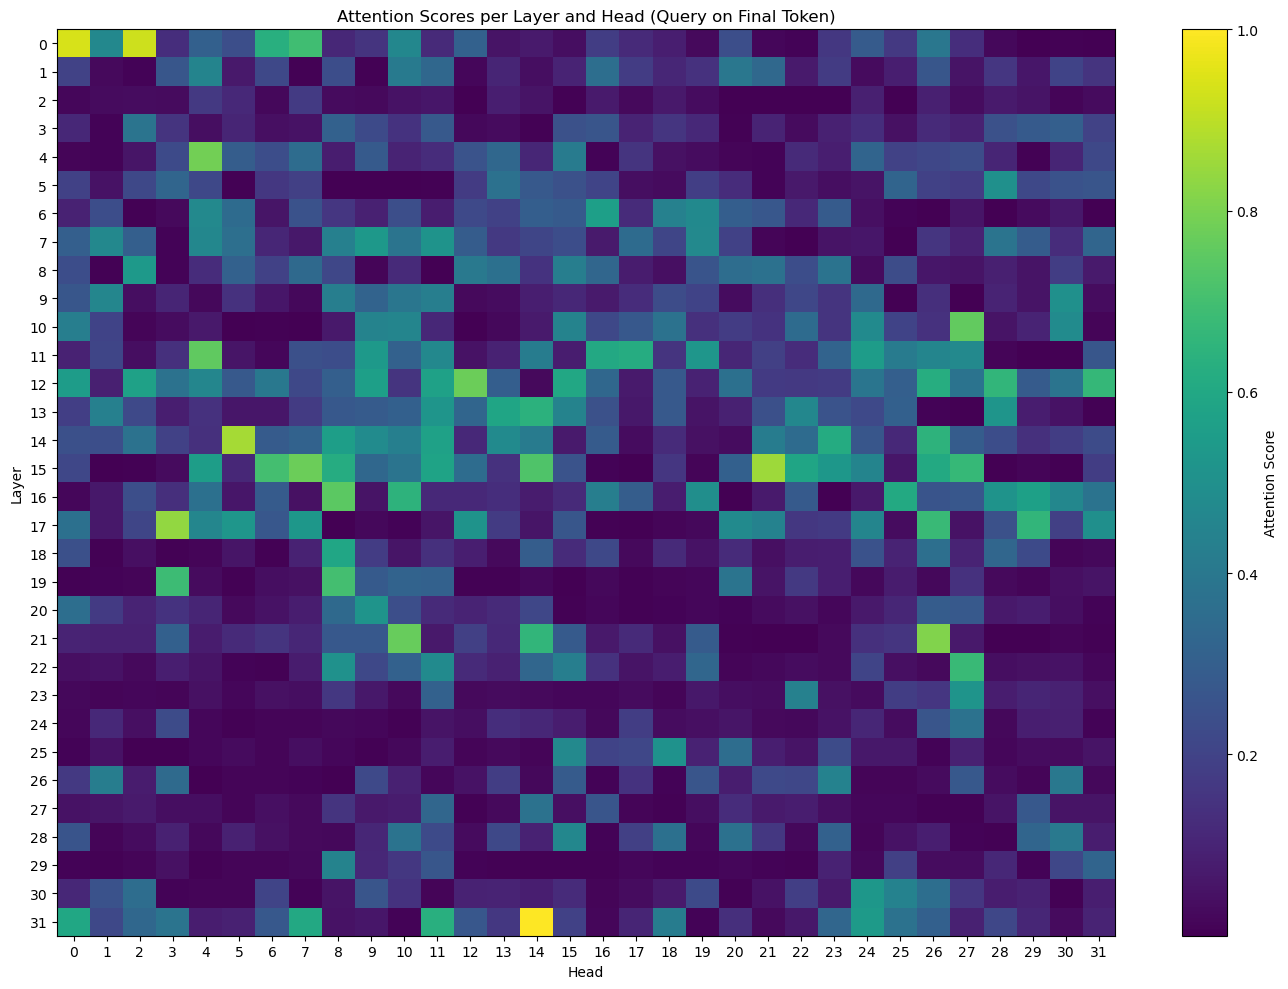

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import re

# === 1. 입력 데이터 준비 ===
# raw_text는 너가 붙여준 전체 텍스트 (레이어와 헤드별 스코어)
raw_text = """
layer0's head0: 0.94140625
layer0's head1: 0.466796875
layer0's head2: 0.92578125
layer0's head3: 0.1328125
layer0's head4: 0.306640625
layer0's head5: 0.2421875
layer0's head6: 0.6328125
layer0's head7: 0.6953125
layer0's head8: 0.10986328125
layer0's head9: 0.150390625
layer0's head10: 0.462890625
layer0's head11: 0.119140625
layer0's head12: 0.3125
layer0's head13: 0.05126953125
layer0's head14: 0.072265625
layer0's head15: 0.035400390625
layer0's head16: 0.1826171875
layer0's head17: 0.1181640625
layer0's head18: 0.08251953125
layer0's head19: 0.0242919921875
layer0's head20: 0.2392578125
layer0's head21: 0.017822265625
layer0's head22: 0.0107421875
layer0's head23: 0.1640625
layer0's head24: 0.2890625
layer0's head25: 0.1650390625
layer0's head26: 0.3984375
layer0's head27: 0.130859375
layer0's head28: 0.0218505859375
layer0's head29: 0.0002689361572265625
layer0's head30: 0.004180908203125
layer0's head31: 3.594905138015747e-07
__________
layer1's head0: 0.1962890625
layer1's head1: 0.0264892578125
layer1's head2: 0.00787353515625
layer1's head3: 0.26953125
layer1's head4: 0.451171875
layer1's head5: 0.06884765625
layer1's head6: 0.2177734375
layer1's head7: 0.00732421875
layer1's head8: 0.236328125
layer1's head9: 0.005126953125
layer1's head10: 0.4140625
layer1's head11: 0.3359375
layer1's head12: 0.01904296875
layer1's head13: 0.1044921875
layer1's head14: 0.03564453125
layer1's head15: 0.10107421875
layer1's head16: 0.361328125
layer1's head17: 0.1767578125
layer1's head18: 0.10888671875
layer1's head19: 0.1416015625
layer1's head20: 0.396484375
layer1's head21: 0.337890625
layer1's head22: 0.0712890625
layer1's head23: 0.17578125
layer1's head24: 0.0294189453125
layer1's head25: 0.08349609375
layer1's head26: 0.26953125
layer1's head27: 0.05322265625
layer1's head28: 0.1591796875
layer1's head29: 0.059814453125
layer1's head30: 0.203125
layer1's head31: 0.1494140625
__________
layer2's head0: 0.0159912109375
layer2's head1: 0.0279541015625
layer2's head2: 0.033447265625
layer2's head3: 0.0308837890625
layer2's head4: 0.1650390625
layer2's head5: 0.1142578125
layer2's head6: 0.021240234375
layer2's head7: 0.171875
layer2's head8: 0.0294189453125
layer2's head9: 0.023681640625
layer2's head10: 0.049560546875
layer2's head11: 0.061767578125
layer2's head12: 0.0027923583984375
layer2's head13: 0.08349609375
layer2's head14: 0.052001953125
layer2's head15: 0.00537109375
layer2's head16: 0.072265625
layer2's head17: 0.0262451171875
layer2's head18: 0.06787109375
layer2's head19: 0.0341796875
layer2's head20: 0.0032196044921875
layer2's head21: 5.73345459997654e-09
layer2's head22: 1.996755599975586e-06
layer2's head23: 1.3560056686401367e-06
layer2's head24: 0.08984375
layer2's head25: 8.0108642578125e-05
layer2's head26: 0.08740234375
layer2's head27: 0.0322265625
layer2's head28: 0.07275390625
layer2's head29: 0.052001953125
layer2's head30: 0.01361083984375
layer2's head31: 0.0306396484375
__________
layer3's head0: 0.10986328125
layer3's head1: 0.0106201171875
layer3's head2: 0.384765625
layer3's head3: 0.15234375
layer3's head4: 0.0361328125
layer3's head5: 0.10205078125
layer3's head6: 0.0400390625
layer3's head7: 0.04931640625
layer3's head8: 0.310546875
layer3's head9: 0.2236328125
layer3's head10: 0.1474609375
layer3's head11: 0.279296875
layer3's head12: 0.02099609375
layer3's head13: 0.03125
layer3's head14: 0.006866455078125
layer3's head15: 0.25
layer3's head16: 0.263671875
layer3's head17: 0.09912109375
layer3's head18: 0.154296875
layer3's head19: 0.1171875
layer3's head20: 0.007415771484375
layer3's head21: 0.1015625
layer3's head22: 0.029541015625
layer3's head23: 0.0927734375
layer3's head24: 0.1328125
layer3's head25: 0.045654296875
layer3's head26: 0.11865234375
layer3's head27: 0.0908203125
layer3's head28: 0.2490234375
layer3's head29: 0.28515625
layer3's head30: 0.3046875
layer3's head31: 0.197265625
__________
layer4's head0: 0.01434326171875
layer4's head1: 0.009765625
layer4's head2: 0.058349609375
layer4's head3: 0.2236328125
layer4's head4: 0.7890625
layer4's head5: 0.294921875
layer4's head6: 0.23828125
layer4's head7: 0.35546875
layer4's head8: 0.0791015625
layer4's head9: 0.283203125
layer4's head10: 0.10107421875
layer4's head11: 0.1259765625
layer4's head12: 0.255859375
layer4's head13: 0.3359375
layer4's head14: 0.1064453125
layer4's head15: 0.41796875
layer4's head16: 0.00970458984375
layer4's head17: 0.150390625
layer4's head18: 0.0458984375
layer4's head19: 0.03173828125
layer4's head20: 0.0142822265625
layer4's head21: 0.0098876953125
layer4's head22: 0.11962890625
layer4's head23: 0.0849609375
layer4's head24: 0.322265625
layer4's head25: 0.19921875
layer4's head26: 0.2119140625
layer4's head27: 0.2333984375
layer4's head28: 0.10205078125
layer4's head29: 0.0067138671875
layer4's head30: 0.10546875
layer4's head31: 0.2158203125
__________
layer5's head0: 0.1943359375
layer5's head1: 0.049072265625
layer5's head2: 0.2158203125
layer5's head3: 0.326171875
layer5's head4: 0.216796875
layer5's head5: 0.0052490234375
layer5's head6: 0.1630859375
layer5's head7: 0.19140625
layer5's head8: 4.792213439941406e-05
layer5's head9: 0.00011587142944335938
layer5's head10: 3.0040740966796875e-05
layer5's head11: 0.004241943359375
layer5's head12: 0.1728515625
layer5's head13: 0.373046875
layer5's head14: 0.28125
layer5's head15: 0.2470703125
layer5's head16: 0.2041015625
layer5's head17: 0.038818359375
layer5's head18: 0.0303955078125
layer5's head19: 0.185546875
layer5's head20: 0.126953125
layer5's head21: 0.00836181640625
layer5's head22: 0.0703125
layer5's head23: 0.0390625
layer5's head24: 0.054443359375
layer5's head25: 0.32421875
layer5's head26: 0.193359375
layer5's head27: 0.1767578125
layer5's head28: 0.50390625
layer5's head29: 0.2177734375
layer5's head30: 0.25390625
layer5's head31: 0.265625
__________
layer6's head0: 0.09521484375
layer6's head1: 0.236328125
layer6's head2: 0.004058837890625
layer6's head3: 0.0252685546875
layer6's head4: 0.470703125
layer6's head5: 0.3515625
layer6's head6: 0.056640625
layer6's head7: 0.25390625
layer6's head8: 0.16015625
layer6's head9: 0.091796875
layer6's head10: 0.240234375
layer6's head11: 0.0791015625
layer6's head12: 0.22265625
layer6's head13: 0.1953125
layer6's head14: 0.298828125
layer6's head15: 0.28515625
layer6's head16: 0.56640625
layer6's head17: 0.125
layer6's head18: 0.44140625
layer6's head19: 0.4765625
layer6's head20: 0.30078125
layer6's head21: 0.2734375
layer6's head22: 0.11669921875
layer6's head23: 0.287109375
layer6's head24: 0.04052734375
layer6's head25: 0.00811767578125
layer6's head26: 0.001861572265625
layer6's head27: 0.057373046875
layer6's head28: 7.104873657226562e-05
layer6's head29: 0.0294189453125
layer6's head30: 0.06591796875
layer6's head31: 1.5497207641601562e-05
__________
layer7's head0: 0.302734375
layer7's head1: 0.46875
layer7's head2: 0.302734375
layer7's head3: 0.0113525390625
layer7's head4: 0.46484375
layer7's head5: 0.365234375
layer7's head6: 0.1083984375
layer7's head7: 0.0634765625
layer7's head8: 0.435546875
layer7's head9: 0.53515625
layer7's head10: 0.384765625
layer7's head11: 0.515625
layer7's head12: 0.29296875
layer7's head13: 0.1669921875
layer7's head14: 0.2099609375
layer7's head15: 0.236328125
layer7's head16: 0.072265625
layer7's head17: 0.3515625
layer7's head18: 0.208984375
layer7's head19: 0.470703125
layer7's head20: 0.1953125
layer7's head21: 0.01409912109375
layer7's head22: 0.0027923583984375
layer7's head23: 0.0546875
layer7's head24: 0.05908203125
layer7's head25: 0.00113677978515625
layer7's head26: 0.154296875
layer7's head27: 0.0966796875
layer7's head28: 0.384765625
layer7's head29: 0.29296875
layer7's head30: 0.126953125
layer7's head31: 0.328125
__________
layer8's head0: 0.23828125
layer8's head1: 0.007080078125
layer8's head2: 0.54296875
layer8's head3: 0.00787353515625
layer8's head4: 0.1259765625
layer8's head5: 0.310546875
layer8's head6: 0.1943359375
layer8's head7: 0.34375
layer8's head8: 0.2138671875
layer8's head9: 0.0145263671875
layer8's head10: 0.1181640625
layer8's head11: 0.001739501953125
layer8's head12: 0.40625
layer8's head13: 0.37109375
layer8's head14: 0.1474609375
layer8's head15: 0.427734375
layer8's head16: 0.33203125
layer8's head17: 0.07568359375
layer8's head18: 0.041748046875
layer8's head19: 0.26171875
layer8's head20: 0.359375
layer8's head21: 0.373046875
layer8's head22: 0.236328125
layer8's head23: 0.380859375
layer8's head24: 0.0308837890625
layer8's head25: 0.2333984375
layer8's head26: 0.059326171875
layer8's head27: 0.052734375
layer8's head28: 0.08984375
layer8's head29: 0.05224609375
layer8's head30: 0.1806640625
layer8's head31: 0.072265625
__________
layer9's head0: 0.26953125
layer9's head1: 0.458984375
layer9's head2: 0.0390625
layer9's head3: 0.10302734375
layer9's head4: 0.0206298828125
layer9's head5: 0.14453125
layer9's head6: 0.06103515625
layer9's head7: 0.0220947265625
layer9's head8: 0.427734375
layer9's head9: 0.318359375
layer9's head10: 0.39453125
layer9's head11: 0.4296875
layer9's head12: 0.025634765625
layer9's head13: 0.033203125
layer9's head14: 0.083984375
layer9's head15: 0.11181640625
layer9's head16: 0.07275390625
layer9's head17: 0.126953125
layer9's head18: 0.234375
layer9's head19: 0.2021484375
layer9's head20: 0.033447265625
layer9's head21: 0.1357421875
layer9's head22: 0.21484375
layer9's head23: 0.150390625
layer9's head24: 0.34375
layer9's head25: 0.00017070770263671875
layer9's head26: 0.134765625
layer9's head27: 0.00213623046875
layer9's head28: 0.099609375
layer9's head29: 0.054443359375
layer9's head30: 0.50390625
layer9's head31: 0.03173828125
__________
layer10's head0: 0.4296875
layer10's head1: 0.201171875
layer10's head2: 0.0135498046875
layer10's head3: 0.033447265625
layer10's head4: 0.0673828125
layer10's head5: 0.0022735595703125
layer10's head6: 0.00445556640625
layer10's head7: 0.001129150390625
layer10's head8: 0.0703125
layer10's head9: 0.44921875
layer10's head10: 0.45703125
layer10's head11: 0.10986328125
layer10's head12: 0.0013275146484375
layer10's head13: 0.021240234375
layer10's head14: 0.07421875
layer10's head15: 0.447265625
layer10's head16: 0.2158203125
layer10's head17: 0.27734375
layer10's head18: 0.376953125
layer10's head19: 0.1376953125
layer10's head20: 0.177734375
layer10's head21: 0.1474609375
layer10's head22: 0.349609375
layer10's head23: 0.15234375
layer10's head24: 0.48046875
layer10's head25: 0.2001953125
layer10's head26: 0.1416015625
layer10's head27: 0.76171875
layer10's head28: 0.0517578125
layer10's head29: 0.1005859375
layer10's head30: 0.484375
layer10's head31: 0.0137939453125
__________
layer11's head0: 0.0966796875
layer11's head1: 0.208984375
layer11's head2: 0.0361328125
layer11's head3: 0.1396484375
layer11's head4: 0.7578125
layer11's head5: 0.056396484375
layer11's head6: 0.018310546875
layer11's head7: 0.2451171875
layer11's head8: 0.236328125
layer11's head9: 0.54296875
layer11's head10: 0.310546875
layer11's head11: 0.466796875
layer11's head12: 0.050537109375
layer11's head13: 0.09716796875
layer11's head14: 0.421875
layer11's head15: 0.08154296875
layer11's head16: 0.60546875
layer11's head17: 0.62109375
layer11's head18: 0.15234375
layer11's head19: 0.52734375
layer11's head20: 0.10693359375
layer11's head21: 0.189453125
layer11's head22: 0.1259765625
layer11's head23: 0.318359375
layer11's head24: 0.5546875
layer11's head25: 0.416015625
layer11's head26: 0.455078125
layer11's head27: 0.47265625
layer11's head28: 0.0120849609375
layer11's head29: 0.0023956298828125
layer11's head30: 0.001068115234375
layer11's head31: 0.26953125
__________
layer12's head0: 0.5546875
layer12's head1: 0.08935546875
layer12's head2: 0.57421875
layer12's head3: 0.376953125
layer12's head4: 0.4609375
layer12's head5: 0.28125
layer12's head6: 0.40234375
layer12's head7: 0.2177734375
layer12's head8: 0.3046875
layer12's head9: 0.56640625
layer12's head10: 0.15234375
layer12's head11: 0.57421875
layer12's head12: 0.77734375
layer12's head13: 0.30078125
layer12's head14: 0.0247802734375
layer12's head15: 0.6015625
layer12's head16: 0.3359375
layer12's head17: 0.07080078125
layer12's head18: 0.279296875
layer12's head19: 0.09765625
layer12's head20: 0.37109375
layer12's head21: 0.171875
layer12's head22: 0.1650390625
layer12's head23: 0.1728515625
layer12's head24: 0.390625
layer12's head25: 0.3046875
layer12's head26: 0.625
layer12's head27: 0.3828125
layer12's head28: 0.66015625
layer12's head29: 0.2890625
layer12's head30: 0.384765625
layer12's head31: 0.66796875
__________
layer13's head0: 0.1865234375
layer13's head1: 0.435546875
layer13's head2: 0.2197265625
layer13's head3: 0.0859375
layer13's head4: 0.14453125
layer13's head5: 0.058837890625
layer13's head6: 0.0625
layer13's head7: 0.1748046875
layer13's head8: 0.27734375
layer13's head9: 0.2890625
layer13's head10: 0.306640625
layer13's head11: 0.5234375
layer13's head12: 0.326171875
layer13's head13: 0.58984375
layer13's head14: 0.64453125
layer13's head15: 0.447265625
layer13's head16: 0.2490234375
layer13's head17: 0.06494140625
layer13's head18: 0.279296875
layer13's head19: 0.052978515625
layer13's head20: 0.09326171875
layer13's head21: 0.2451171875
layer13's head22: 0.462890625
layer13's head23: 0.255859375
layer13's head24: 0.220703125
layer13's head25: 0.30859375
layer13's head26: 0.011474609375
layer13's head27: 0.002044677734375
layer13's head28: 0.5234375
layer13's head29: 0.08154296875
layer13's head30: 0.047607421875
layer13's head31: 0.00531005859375
__________
layer14's head0: 0.244140625
layer14's head1: 0.2421875
layer14's head2: 0.376953125
layer14's head3: 0.193359375
layer14's head4: 0.1376953125
layer14's head5: 0.8671875
layer14's head6: 0.2890625
layer14's head7: 0.31640625
layer14's head8: 0.5625
layer14's head9: 0.484375
layer14's head10: 0.43359375
layer14's head11: 0.57421875
layer14's head12: 0.11474609375
layer14's head13: 0.48046875
layer14's head14: 0.416015625
layer14's head15: 0.07080078125
layer14's head16: 0.2890625
layer14's head17: 0.0341796875
layer14's head18: 0.12255859375
layer14's head19: 0.044189453125
layer14's head20: 0.033447265625
layer14's head21: 0.419921875
layer14's head22: 0.349609375
layer14's head23: 0.6171875
layer14's head24: 0.26953125
layer14's head25: 0.1162109375
layer14's head26: 0.6484375
layer14's head27: 0.291015625
layer14's head28: 0.236328125
layer14's head29: 0.140625
layer14's head30: 0.1826171875
layer14's head31: 0.2294921875
__________
layer15's head0: 0.212890625
layer15's head1: 0.002044677734375
layer15's head2: 0.007537841796875
layer15's head3: 0.028076171875
layer15's head4: 0.55859375
layer15's head5: 0.11279296875
layer15's head6: 0.703125
layer15's head7: 0.77734375
layer15's head8: 0.62109375
layer15's head9: 0.3359375
layer15's head10: 0.384765625
layer15's head11: 0.58203125
layer15's head12: 0.35546875
layer15's head13: 0.1416015625
layer15's head14: 0.7265625
layer15's head15: 0.2578125
layer15's head16: 0.0115966796875
layer15's head17: 0.0034942626953125
layer15's head18: 0.16015625
layer15's head19: 0.01361083984375
layer15's head20: 0.30859375
layer15's head21: 0.85546875
layer15's head22: 0.58984375
layer15's head23: 0.53125
layer15's head24: 0.453125
layer15's head25: 0.060302734375
layer15's head26: 0.609375
layer15's head27: 0.671875
layer15's head28: 0.0003795623779296875
layer15's head29: 0.0135498046875
layer15's head30: 0.0021209716796875
layer15's head31: 0.181640625
__________
layer16's head0: 0.017822265625
layer16's head1: 0.06494140625
layer16's head2: 0.2421875
layer16's head3: 0.134765625
layer16's head4: 0.369140625
layer16's head5: 0.0615234375
layer16's head6: 0.287109375
layer16's head7: 0.04443359375
layer16's head8: 0.75
layer16's head9: 0.052978515625
layer16's head10: 0.6484375
layer16's head11: 0.11669921875
layer16's head12: 0.11669921875
layer16's head13: 0.130859375
layer16's head14: 0.0771484375
layer16's head15: 0.11865234375
layer16's head16: 0.4296875
layer16's head17: 0.294921875
layer16's head18: 0.08203125
layer16's head19: 0.494140625
layer16's head20: 0.000789642333984375
layer16's head21: 0.0712890625
layer16's head22: 0.283203125
layer16's head23: 0.0026397705078125
layer16's head24: 0.0703125
layer16's head25: 0.609375
layer16's head26: 0.259765625
layer16's head27: 0.271484375
layer16's head28: 0.515625
layer16's head29: 0.5703125
layer16's head30: 0.462890625
layer16's head31: 0.380859375
__________
layer17's head0: 0.37109375
layer17's head1: 0.06494140625
layer17's head2: 0.2099609375
layer17's head3: 0.83984375
layer17's head4: 0.458984375
layer17's head5: 0.52734375
layer17's head6: 0.271484375
layer17's head7: 0.53125
layer17's head8: 0.00081634521484375
layer17's head9: 0.021240234375
layer17's head10: 0.0107421875
layer17's head11: 0.057861328125
layer17's head12: 0.515625
layer17's head13: 0.173828125
layer17's head14: 0.05712890625
layer17's head15: 0.267578125
layer17's head16: 0.00537109375
layer17's head17: 0.0016937255859375
layer17's head18: 0.01422119140625
layer17's head19: 0.0201416015625
layer17's head20: 0.48046875
layer17's head21: 0.4453125
layer17's head22: 0.162109375
layer17's head23: 0.171875
layer17's head24: 0.455078125
layer17's head25: 0.033447265625
layer17's head26: 0.6796875
layer17's head27: 0.048095703125
layer17's head28: 0.2470703125
layer17's head29: 0.66015625
layer17's head30: 0.189453125
layer17's head31: 0.498046875
__________
layer18's head0: 0.2451171875
layer18's head1: 0.007049560546875
layer18's head2: 0.04052734375
layer18's head3: 0.0072021484375
layer18's head4: 0.01214599609375
layer18's head5: 0.057861328125
layer18's head6: 0.0068359375
layer18's head7: 0.09619140625
layer18's head8: 0.59375
layer18's head9: 0.177734375
layer18's head10: 0.0576171875
layer18's head11: 0.1396484375
layer18's head12: 0.0830078125
layer18's head13: 0.0264892578125
layer18's head14: 0.294921875
layer18's head15: 0.12451171875
layer18's head16: 0.2177734375
layer18's head17: 0.0257568359375
layer18's head18: 0.12060546875
layer18's head19: 0.05078125
layer18's head20: 0.1240234375
layer18's head21: 0.04248046875
layer18's head22: 0.080078125
layer18's head23: 0.0849609375
layer18's head24: 0.25390625
layer18's head25: 0.1005859375
layer18's head26: 0.365234375
layer18's head27: 0.1015625
layer18's head28: 0.330078125
layer18's head29: 0.2236328125
layer18's head30: 0.01226806640625
layer18's head31: 0.022216796875
__________
layer19's head0: 0.00537109375
layer19's head1: 0.01080322265625
layer19's head2: 0.0120849609375
layer19's head3: 0.6875
layer19's head4: 0.0274658203125
layer19's head5: 0.00701904296875
layer19's head6: 0.03759765625
layer19's head7: 0.044189453125
layer19's head8: 0.703125
layer19's head9: 0.28515625
layer19's head10: 0.318359375
layer19's head11: 0.310546875
layer19's head12: 0.004852294921875
layer19's head13: 0.00396728515625
layer19's head14: 0.0218505859375
layer19's head15: 0.0013580322265625
layer19's head16: 0.023193359375
layer19's head17: 0.00616455078125
layer19's head18: 0.0150146484375
layer19's head19: 0.0194091796875
layer19's head20: 0.384765625
layer19's head21: 0.053955078125
layer19's head22: 0.1669921875
layer19's head23: 0.08251953125
layer19's head24: 0.0196533203125
layer19's head25: 0.076171875
layer19's head26: 0.0223388671875
layer19's head27: 0.14453125
layer19's head28: 0.02685546875
layer19's head29: 0.013671875
layer19's head30: 0.041748046875
layer19's head31: 0.05224609375
__________
layer20's head0: 0.361328125
layer20's head1: 0.169921875
layer20's head2: 0.09912109375
layer20's head3: 0.1455078125
layer20's head4: 0.10400390625
layer20's head5: 0.0272216796875
layer20's head6: 0.04931640625
layer20's head7: 0.08056640625
layer20's head8: 0.34375
layer20's head9: 0.51953125
layer20's head10: 0.2421875
layer20's head11: 0.11962890625
layer20's head12: 0.09912109375
layer20's head13: 0.11865234375
layer20's head14: 0.212890625
layer20's head15: 0.0078125
layer20's head16: 0.01953125
layer20's head17: 0.007598876953125
layer20's head18: 0.010986328125
layer20's head19: 0.0164794921875
layer20's head20: 0.01043701171875
layer20's head21: 0.028076171875
layer20's head22: 0.046142578125
layer20's head23: 0.0167236328125
layer20's head24: 0.0693359375
layer20's head25: 0.10693359375
layer20's head26: 0.291015625
layer20's head27: 0.279296875
layer20's head28: 0.0673828125
layer20's head29: 0.08203125
layer20's head30: 0.03564453125
layer20's head31: 0.00927734375
__________
layer21's head0: 0.09912109375
layer21's head1: 0.09130859375
layer21's head2: 0.091796875
layer21's head3: 0.30859375
layer21's head4: 0.07470703125
layer21's head5: 0.11865234375
layer21's head6: 0.15234375
layer21's head7: 0.10888671875
layer21's head8: 0.275390625
layer21's head9: 0.27734375
layer21's head10: 0.76953125
layer21's head11: 0.06884765625
layer21's head12: 0.19140625
layer21's head13: 0.1142578125
layer21's head14: 0.66015625
layer21's head15: 0.283203125
layer21's head16: 0.0703125
layer21's head17: 0.12060546875
layer21's head18: 0.04443359375
layer21's head19: 0.287109375
layer21's head20: 0.0064697265625
layer21's head21: 0.0015869140625
layer21's head22: 0.0015716552734375
layer21's head23: 0.0263671875
layer21's head24: 0.1376953125
layer21's head25: 0.154296875
layer21's head26: 0.8125
layer21's head27: 0.06689453125
layer21's head28: 0.0038299560546875
layer21's head29: 0.0032196044921875
layer21's head30: 0.012451171875
layer21's head31: 0.00640869140625
__________
layer22's head0: 0.0419921875
layer22's head1: 0.04736328125
layer22's head2: 0.0272216796875
layer22's head3: 0.08544921875
layer22's head4: 0.052490234375
layer22's head5: 0.010986328125
layer22's head6: 0.006591796875
layer22's head7: 0.07568359375
layer22's head8: 0.5078125
layer22's head9: 0.2158203125
layer22's head10: 0.310546875
layer22's head11: 0.478515625
layer22's head12: 0.12109375
layer22's head13: 0.091796875
layer22's head14: 0.33203125
layer22's head15: 0.4296875
layer22's head16: 0.1416015625
layer22's head17: 0.05322265625
layer22's head18: 0.08154296875
layer22's head19: 0.33203125
layer22's head20: 0.01312255859375
layer22's head21: 0.021484375
layer22's head22: 0.03515625
layer22's head23: 0.0264892578125
layer22's head24: 0.2060546875
layer22's head25: 0.03955078125
layer22's head26: 0.0257568359375
layer22's head27: 0.6796875
layer22's head28: 0.038330078125
layer22's head29: 0.0439453125
layer22's head30: 0.05078125
layer22's head31: 0.019287109375
__________
layer23's head0: 0.022216796875
layer23's head1: 0.01544189453125
layer23's head2: 0.0172119140625
layer23's head3: 0.0130615234375
layer23's head4: 0.04345703125
layer23's head5: 0.0157470703125
layer23's head6: 0.046630859375
layer23's head7: 0.037109375
layer23's head8: 0.1611328125
layer23's head9: 0.06494140625
layer23's head10: 0.025146484375
layer23's head11: 0.3125
layer23's head12: 0.0238037109375
layer23's head13: 0.0306396484375
layer23's head14: 0.025146484375
layer23's head15: 0.0169677734375
layer23's head16: 0.0174560546875
layer23's head17: 0.027587890625
layer23's head18: 0.01458740234375
layer23's head19: 0.06591796875
layer23's head20: 0.03662109375
layer23's head21: 0.031494140625
layer23's head22: 0.439453125
layer23's head23: 0.04345703125
layer23's head24: 0.0283203125
layer23's head25: 0.1826171875
layer23's head26: 0.1572265625
layer23's head27: 0.51953125
layer23's head28: 0.07861328125
layer23's head29: 0.10302734375
layer23's head30: 0.09130859375
layer23's head31: 0.040283203125
__________
layer24's head0: 0.0172119140625
layer24's head1: 0.115234375
layer24's head2: 0.04296875
layer24's head3: 0.23046875
layer24's head4: 0.0166015625
layer24's head5: 0.00421142578125
layer24's head6: 0.0142822265625
layer24's head7: 0.01495361328125
layer24's head8: 0.023193359375
layer24's head9: 0.0164794921875
layer24's head10: 0.00775146484375
layer24's head11: 0.054443359375
layer24's head12: 0.03564453125
layer24's head13: 0.130859375
layer24's head14: 0.1103515625
layer24's head15: 0.08154296875
layer24's head16: 0.02099609375
layer24's head17: 0.181640625
layer24's head18: 0.031494140625
layer24's head19: 0.04248046875
layer24's head20: 0.05615234375
layer24's head21: 0.026123046875
layer24's head22: 0.02001953125
layer24's head23: 0.0498046875
layer24's head24: 0.109375
layer24's head25: 0.032958984375
layer24's head26: 0.265625
layer24's head27: 0.37890625
layer24's head28: 0.0213623046875
layer24's head29: 0.083984375
layer24's head30: 0.087890625
layer24's head31: 0.0107421875
__________
layer25's head0: 0.00958251953125
layer25's head1: 0.05078125
layer25's head2: 0.0005645751953125
layer25's head3: 0.003662109375
layer25's head4: 0.016845703125
layer25's head5: 0.0289306640625
layer25's head6: 0.01226806640625
layer25's head7: 0.03662109375
layer25's head8: 0.0186767578125
layer25's head9: 0.0078125
layer25's head10: 0.0224609375
layer25's head11: 0.0810546875
layer25's head12: 0.01495361328125
layer25's head13: 0.023681640625
layer25's head14: 0.0123291015625
layer25's head15: 0.470703125
layer25's head16: 0.2001953125
layer25's head17: 0.2138671875
layer25's head18: 0.51171875
layer25's head19: 0.0966796875
layer25's head20: 0.357421875
layer25's head21: 0.0830078125
layer25's head22: 0.053466796875
layer25's head23: 0.228515625
layer25's head24: 0.0654296875
layer25's head25: 0.06298828125
layer25's head26: 0.00958251953125
layer25's head27: 0.09375
layer25's head28: 0.0185546875
layer25's head29: 0.0322265625
layer25's head30: 0.029296875
layer25's head31: 0.054443359375
__________
layer26's head0: 0.16796875
layer26's head1: 0.42578125
layer26's head2: 0.0771484375
layer26's head3: 0.34765625
layer26's head4: 0.003814697265625
layer26's head5: 0.014892578125
layer26's head6: 0.0126953125
layer26's head7: 0.009033203125
layer26's head8: 0.003662109375
layer26's head9: 0.22265625
layer26's head10: 0.091796875
layer26's head11: 0.017578125
layer26's head12: 0.05078125
layer26's head13: 0.181640625
layer26's head14: 0.0218505859375
layer26's head15: 0.287109375
layer26's head16: 0.0086669921875
layer26's head17: 0.1474609375
layer26's head18: 0.010498046875
layer26's head19: 0.263671875
layer26's head20: 0.07861328125
layer26's head21: 0.22265625
layer26's head22: 0.21484375
layer26's head23: 0.443359375
layer26's head24: 0.0135498046875
layer26's head25: 0.01220703125
layer26's head26: 0.0311279296875
layer26's head27: 0.27734375
layer26's head28: 0.03515625
layer26's head29: 0.01263427734375
layer26's head30: 0.400390625
layer26's head31: 0.019775390625
__________
layer27's head0: 0.047607421875
layer27's head1: 0.05615234375
layer27's head2: 0.07421875
layer27's head3: 0.037841796875
layer27's head4: 0.03759765625
layer27's head5: 0.015625
layer27's head6: 0.041015625
layer27's head7: 0.02392578125
layer27's head8: 0.1494140625
layer27's head9: 0.0703125
layer27's head10: 0.07568359375
layer27's head11: 0.33203125
layer27's head12: 0.006683349609375
layer27's head13: 0.02734375
layer27's head14: 0.376953125
layer27's head15: 0.0419921875
layer27's head16: 0.263671875
layer27's head17: 0.01458740234375
layer27's head18: 0.007537841796875
layer27's head19: 0.038818359375
layer27's head20: 0.126953125
layer27's head21: 0.07177734375
layer27's head22: 0.0791015625
layer27's head23: 0.03955078125
layer27's head24: 0.015869140625
layer27's head25: 0.01708984375
layer27's head26: 0.0047607421875
layer27's head27: 0.003997802734375
layer27's head28: 0.051025390625
layer27's head29: 0.27734375
layer27's head30: 0.05224609375
layer27's head31: 0.051513671875
__________
layer28's head0: 0.259765625
layer28's head1: 0.01324462890625
layer28's head2: 0.0322265625
layer28's head3: 0.09130859375
layer28's head4: 0.0224609375
layer28's head5: 0.09326171875
layer28's head6: 0.046875
layer28's head7: 0.0263671875
layer28's head8: 0.0224609375
layer28's head9: 0.1083984375
layer28's head10: 0.380859375
layer28's head11: 0.2265625
layer28's head12: 0.0286865234375
layer28's head13: 0.2158203125
layer28's head14: 0.09765625
layer28's head15: 0.46484375
layer28's head16: 0.00994873046875
layer28's head17: 0.19140625
layer28's head18: 0.37109375
layer28's head19: 0.0191650390625
layer28's head20: 0.373046875
layer28's head21: 0.1640625
layer28's head22: 0.0213623046875
layer28's head23: 0.3125
layer28's head24: 0.01312255859375
layer28's head25: 0.05078125
layer28's head26: 0.08251953125
layer28's head27: 0.00927734375
layer28's head28: 0.006988525390625
layer28's head29: 0.326171875
layer28's head30: 0.404296875
layer28's head31: 0.07861328125
__________
layer29's head0: 0.00982666015625
layer29's head1: 0.007720947265625
layer29's head2: 0.01177978515625
layer29's head3: 0.043701171875
layer29's head4: 0.0048828125
layer29's head5: 0.01495361328125
layer29's head6: 0.015625
layer29's head7: 0.0203857421875
layer29's head8: 0.447265625
layer29's head9: 0.11181640625
layer29's head10: 0.162109375
layer29's head11: 0.26953125
layer29's head12: 0.01007080078125
layer29's head13: 0.003936767578125
layer29's head14: 0.0047607421875
layer29's head15: 0.0076904296875
layer29's head16: 0.005279541015625
layer29's head17: 0.016845703125
layer29's head18: 0.00811767578125
layer29's head19: 0.010009765625
layer29's head20: 0.015869140625
layer29's head21: 0.00848388671875
layer29's head22: 0.00775146484375
layer29's head23: 0.0966796875
layer29's head24: 0.0198974609375
layer29's head25: 0.1904296875
layer29's head26: 0.0322265625
layer29's head27: 0.033203125
layer29's head28: 0.11181640625
layer29's head29: 0.0098876953125
layer29's head30: 0.2138671875
layer29's head31: 0.322265625
__________
layer30's head0: 0.11083984375
layer30's head1: 0.25390625
layer30's head2: 0.359375
layer30's head3: 0.00897216796875
layer30's head4: 0.012451171875
layer30's head5: 0.0118408203125
layer30's head6: 0.205078125
layer30's head7: 0.01153564453125
layer30's head8: 0.052001953125
layer30's head9: 0.265625
layer30's head10: 0.1474609375
layer30's head11: 0.0135498046875
layer30's head12: 0.0947265625
layer30's head13: 0.09912109375
layer30's head14: 0.0859375
layer30's head15: 0.12255859375
layer30's head16: 0.01507568359375
layer30's head17: 0.03369140625
layer30's head18: 0.0712890625
layer30's head19: 0.2236328125
layer30's head20: 0.006500244140625
layer30's head21: 0.05029296875
layer30's head22: 0.1875
layer30's head23: 0.07421875
layer30's head24: 0.53125
layer30's head25: 0.4453125
layer30's head26: 0.361328125
layer30's head27: 0.16015625
layer30's head28: 0.0810546875
layer30's head29: 0.09521484375
layer30's head30: 0.0069580078125
layer30's head31: 0.083984375
__________
layer31's head0: 0.59765625
layer31's head1: 0.2158203125
layer31's head2: 0.3359375
layer31's head3: 0.384765625
layer31's head4: 0.07861328125
layer31's head5: 0.09375
layer31's head6: 0.275390625
layer31's head7: 0.60546875
layer31's head8: 0.050048828125
layer31's head9: 0.061767578125
layer31's head10: 0.01092529296875
layer31's head11: 0.6328125
layer31's head12: 0.2734375
layer31's head13: 0.1611328125
layer31's head14: 1.0
layer31's head15: 0.1923828125
layer31's head16: 0.01611328125
layer31's head17: 0.103515625
layer31's head18: 0.421875
layer31's head19: 0.01080322265625
layer31's head20: 0.1337890625
layer31's head21: 0.025146484375
layer31's head22: 0.064453125
layer31's head23: 0.330078125
layer31's head24: 0.546875
layer31's head25: 0.376953125
layer31's head26: 0.30859375
layer31's head27: 0.091796875
layer31's head28: 0.2119140625
layer31's head29: 0.10693359375
layer31's head30: 0.030029296875
layer31's head31: 0.1015625
__________"""

# === 2. 데이터 파싱 ===
pattern = r"layer(\d+)'s head(\d+): ([0-9.eE+-]+)"
matches = re.findall(pattern, raw_text)

# 28개 레이어 × 28개 헤드 스코어 저장용 배열
num_layers = 32
num_heads = 32
attention_scores = np.zeros((num_layers, num_heads))

# 파싱된 값들 배열에 채워 넣기
for layer, head, score in matches:
    layer = int(layer)
    head = int(head)
    score = float(score)
    attention_scores[layer, head] = score

# === 3. 시각화 ===
fig, ax = plt.subplots(figsize=(14, 10))
cax = ax.imshow(attention_scores, aspect='auto', cmap='viridis')
fig.colorbar(cax, ax=ax, label='Attention Score')

# 축 레이블 및 제목 설정
ax.set_title("Attention Scores per Layer and Head (Query on Final Token)")
ax.set_xlabel("Head")
ax.set_ylabel("Layer")
ax.set_xticks(np.arange(num_heads))
ax.set_yticks(np.arange(num_layers))
ax.set_xticklabels(np.arange(num_heads))
ax.set_yticklabels(np.arange(num_layers))

plt.tight_layout()
plt.show()